# Dataset bajo Bag of Visual Words

Este notebook de Python tratará la creación del archivo con la cual se entrenará la red FeedForward para cada característica (si es vehículo o no, el tipo de vehículo y la marca del mismo), recuerde cambiar los datos con los cuales se hará al momento de inicializar el algoritmo.

In [1]:
#Importamos las librerías de costumbre
import numpy as np
import pandas as pd
#Instalamos la librería que nos va a permitir bajar de drive

In [1]:
!pip install gdown
import gdown
#Colocamos la URL del archivo
url = 'https://drive.google.com/uc?id=16OaCBYnHF-OMe784Trvpi-DQoEMFyBLZ'
#Colocamos el nombre al archivo donde la información será guardada
Nombre = '../Datasets/TipoVehiculo.rar'
#Lo descargamos
gdown.download(url,Nombre,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16OaCBYnHF-OMe784Trvpi-DQoEMFyBLZ
To: /home/slbejaranom/work/home/ConteoEIdentificacionDeTrafico/Datasets/TipoVehiculo.rar
3.97GB [09:18, 7.11MB/s]


'../Datasets/TipoVehiculo.rar'

In [3]:
#Una vez descargado lo extraemos, para eso hacemos uso de las librerías patool y pyunpack
!pip install patool pyunpack
from pyunpack import Archive

#Extraemos
Archive('../Datasets/TipoVehiculo.rar').extractall('../Datasets')
print("Extraído satisfactoriamente")

Extraído satisfactoriamente


In [2]:
#Ahora vamos a pasar a la parte sucia, para eso primero instalamos opencv contrib
!pip install opencv-contrib-python
import cv2
import os

In [3]:
#Damos el nombre de la carpeta en la que se encuentra el dataset
dataset = "../Datasets/TipoVehiculo"
#Para las clases lo que hacemos es listar los nombres de las carpetas que se encuentran por dentro, se listan en orden alfabético
training_names = os.listdir(dataset)

#Ahora vamos a tener las variables para todas las imágenes
#La variable image_paths guardará las rutas de las imágenes
image_paths = []
image_classes = []
class_id = 0

def imglist(path):
    return [os.path.join(path,f) for f in os.listdir(path)]

for training_name in training_names:
    dir = os.path.join(dataset, training_name)
    class_path = imglist(dir)
    image_paths += class_path
    image_classes += [class_id]*len(class_path)
    class_id += 1

In [9]:
#Ahora crearemos una lista para tener la lista de descriptores que hallaremos a partir del SIFT
des_list = []
#Creamos el extractor SIFT con 50 puntos clave por imagen
sift = cv2.SIFT_create(50)
#Cogemos cada imagen, le pasamos el SIFT y los apilamos en des_list de la siguiente manera
#NOMBRE DEL ARCHIVO, DESCRIPTORES
for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    del im
    des_list.append((image_path,des))

In [10]:
#Ahora vamos a apilar todos los descriptores de manera vertical
descriptors = des_list[0][1]
#Hay que descartar los descriptores que son None
for image_path, descriptor in des_list[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        
#Para hacer K Means es necesario que los datos estén en tipo float por lo que la siguiente linea es necesaria
descriptors_float = descriptors.astype(float)

In [24]:
np.shape(descriptors_float)

(854798, 128)

## K Means
Acá viene la parte del K Means, en esta sección es necesario el estudio del codo en la gráfica para saber qué valor de K podríamos utilizar que no sea de gasto computacional pero que tampoco quite exactitud

In [27]:
from scipy.cluster.vq import kmeans, vq

varianzas = []
num_clusters = range(100,2500,100)

for k in num_clusters:
    centroide, varianza = kmeans(descriptors_float, k, 1)
    varianzas.append(varianza)
    print("Con "+str(k)+" clusters, ya se hizo")


Con 100 clusters, ya se hizo
Con 200 clusters, ya se hizo
Con 300 clusters, ya se hizo
Con 400 clusters, ya se hizo
Con 500 clusters, ya se hizo
Con 600 clusters, ya se hizo
Con 700 clusters, ya se hizo
Con 800 clusters, ya se hizo
Con 900 clusters, ya se hizo
Con 1000 clusters, ya se hizo
Con 1100 clusters, ya se hizo
Con 1200 clusters, ya se hizo
Con 1300 clusters, ya se hizo
Con 1400 clusters, ya se hizo
Con 1500 clusters, ya se hizo
Con 1600 clusters, ya se hizo
Con 1700 clusters, ya se hizo
Con 1800 clusters, ya se hizo
Con 1900 clusters, ya se hizo
Con 2000 clusters, ya se hizo
Con 2100 clusters, ya se hizo
Con 2200 clusters, ya se hizo
Con 2300 clusters, ya se hizo
Con 2400 clusters, ya se hizo


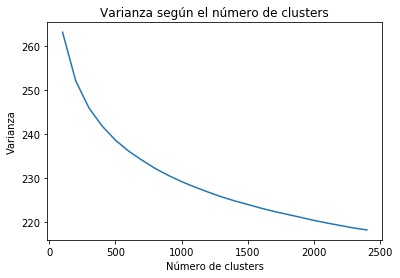

In [29]:
elbow_plot_data = pd.DataFrame({'num_clusters':num_clusters,
                               'disortions':varianzas})

import seaborn as sns
from matplotlib import pyplot as plt

sns.lineplot(x = 'num_clusters',y = 'disortions', data = elbow_plot_data)

plt.xlabel("Número de clusters")
plt.ylabel("Varianza")
plt.title("Varianza según el número de clusters")
plt.show()

In [ ]:
#Con 1000 clusters ya podríamos obtener una buena división ya que luego baja a una tasa más lenta.
k = 1500
voc, variance = kmeans(descriptors_float,k,2)

In [34]:
#Creamos un vector de características vacío
im_features = np.zeros((len(image_paths),k),"float32")
#Ahora procedemos a obtener los histogramas para cada imagen
for i in range(len(image_paths)):
    if des_list[i][1] is not None:
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

In [35]:
#Hacemos la vectorización Tf-Idf
nbr_ocurrences = np.sum((im_features > 0)*1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_ocurrences + 1)), "float32")

In [36]:
#Lo próximo que haremos será normalizar los valores
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
#Después de esto ya tenemos listo para guardar el archivo CSV

In [37]:
#Esto lo hacemos para tener salidas y entradas en un mismo arreglo para generar el CSV
DataSet = []
for i in range(len(image_classes)):
    DataSet.append(np.append(im_features[i],image_classes[i]))

In [38]:
#Guardamos el dataset
pd.DataFrame(DataSet).to_csv("DataSet_Tipo.csv", header=False, index=False)

In [39]:
#Guardamos la configuración (El Standard Scaler y el K con el que hicimos el K Means)
!pip install joblib
import joblib
joblib.dump((stdSlr,k,voc),"Config_BoVW_Tipo.pkl",compress = 3)

['Config_BoVW_Tipo.pkl']